In [60]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.observables import nrmse, rsquare

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

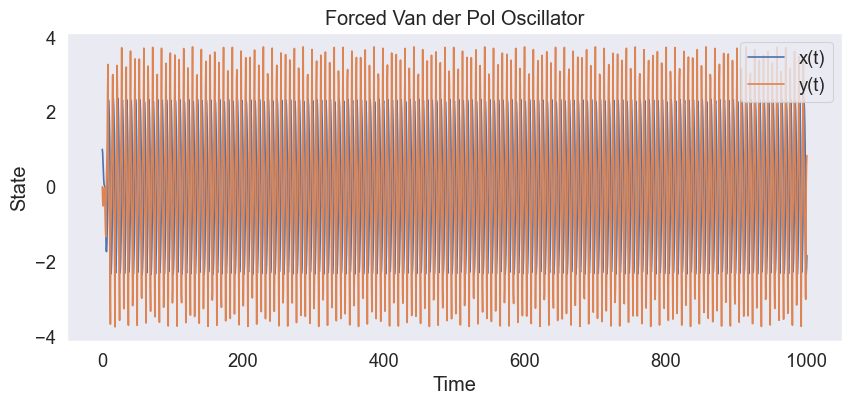

In [61]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt

def forced_van_der_pol(t, z, mu, A, omega):
    x, y = z
    dxdt = y
    dydt = mu * (1 - x**2) * y - x + A * np.sin(omega * t)
    return [dxdt, dydt]

mu = 1.0
A = 1.0
omega = 1.0
initial_state = [1.0, 0.0]
t_span = (0, 1000)

sol = solve_ivp(forced_van_der_pol, t_span, initial_state, args=(mu, A, omega), dense_output=True, t_eval=np.linspace(t_span[0], t_span[1], 2000))

t = sol.t
z = sol.y

# CSVファイルにデータを保存
data = pd.DataFrame({'Time': t, 'x': z[0], 'y': z[1]})
data.to_csv('forced_vanderpol_dataset.csv', index=False)

# CSVファイルを読み込む
data_loaded = pd.read_csv('forced_vanderpol_dataset.csv')

# データをプロット
plt.figure(figsize=(10, 4))
plt.plot(data_loaded['Time'], data_loaded['x'], label='x(t)')
plt.plot(data_loaded['Time'], data_loaded['y'], label='y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.grid()
plt.title('Forced Van der Pol Oscillator')
plt.show()


In [62]:
X = data

In [63]:
def plot_vanderpol(X, t_span, timesteps):
    t = np.linspace(0, t_span[1], timesteps)
    z = sol.sol(t)

    plt.figure(figsize=(10, 4))
    plt.plot(t, z[0], label='x(t)')
    plt.plot(t, z[1], label='y(t)')
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.legend()
    plt.grid()
    plt.title('Forced Van der Pol Oscillator')
    plt.show()

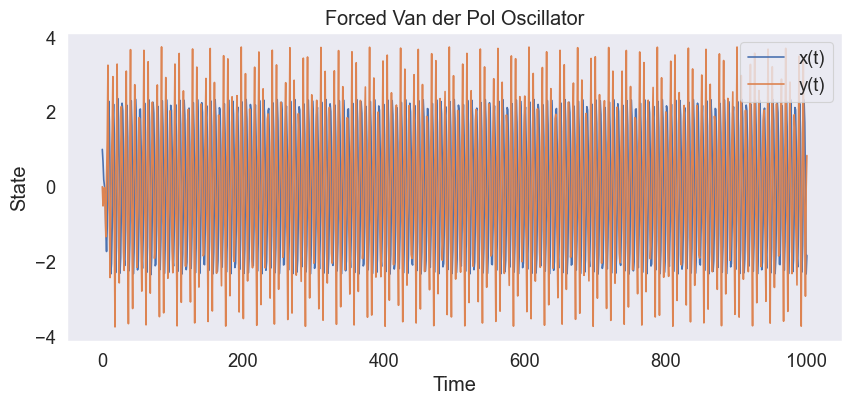

In [64]:
plot_vanderpol(X, t_span, 1000)

In [65]:
t = np.linspace(t_span[0], t_span[1], 1000)
z = sol.sol(t)

data = pd.DataFrame({'Time': t, 'x': z[0], 'y': z[1]})
data.to_csv('vanderpol_dataset.csv', index=False)

X = data.values
timesteps =t_span[1]

In [66]:
X

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.00100100e+00,  6.67386353e-01, -5.14492031e-01],
       [ 2.00200200e+00,  1.92659504e-01, -3.51727347e-01],
       ...,
       [ 9.97997998e+02,  4.69368352e-02, -2.92924533e+00],
       [ 9.98998999e+02, -2.33725501e+00, -7.09705576e-02],
       [ 1.00000000e+03, -1.83850978e+00,  8.35464407e-01]])

In [67]:
def plot_vanderpol_3d(X, timesteps):
    # 3D プロットの作成
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_title("Van Der Pol Oscillator")
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.grid(False)

    for i in range(timesteps-1):
        ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

    plt.show()

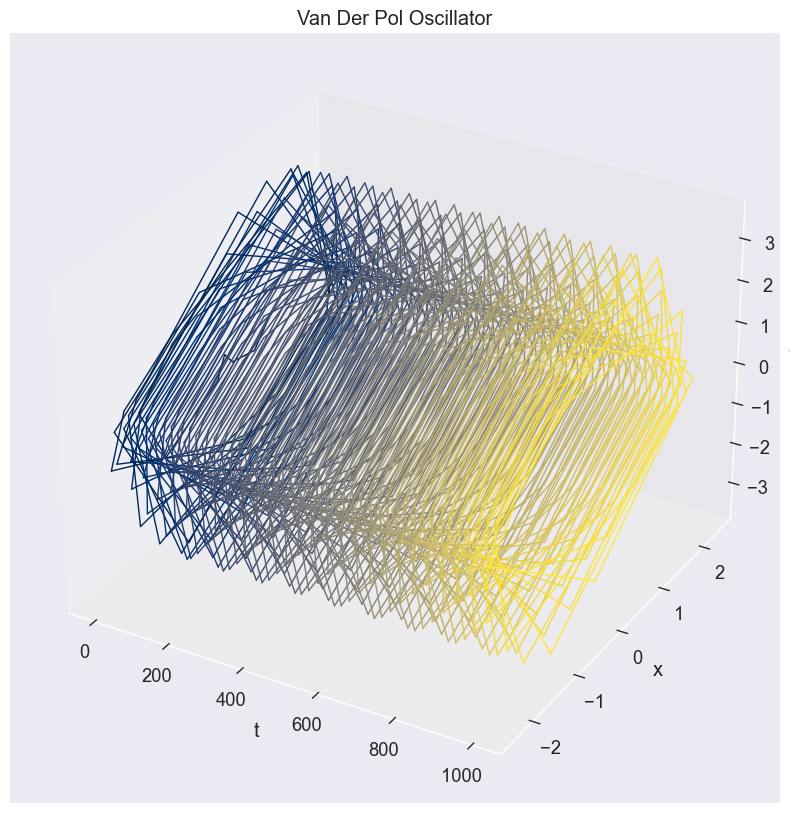

In [68]:
plot_vanderpol_3d(X, 1000)

In [69]:
def plot_vanderpol_2d(X, timesteps):
    # 2D プロットの作成
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Van Der Pol Oscillator (xy plane)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # 軌跡の描画
    for i in range(timesteps-1):
        ax.plot(X[i:i+2, 0], X[i:i+2, 1], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

    plt.show()


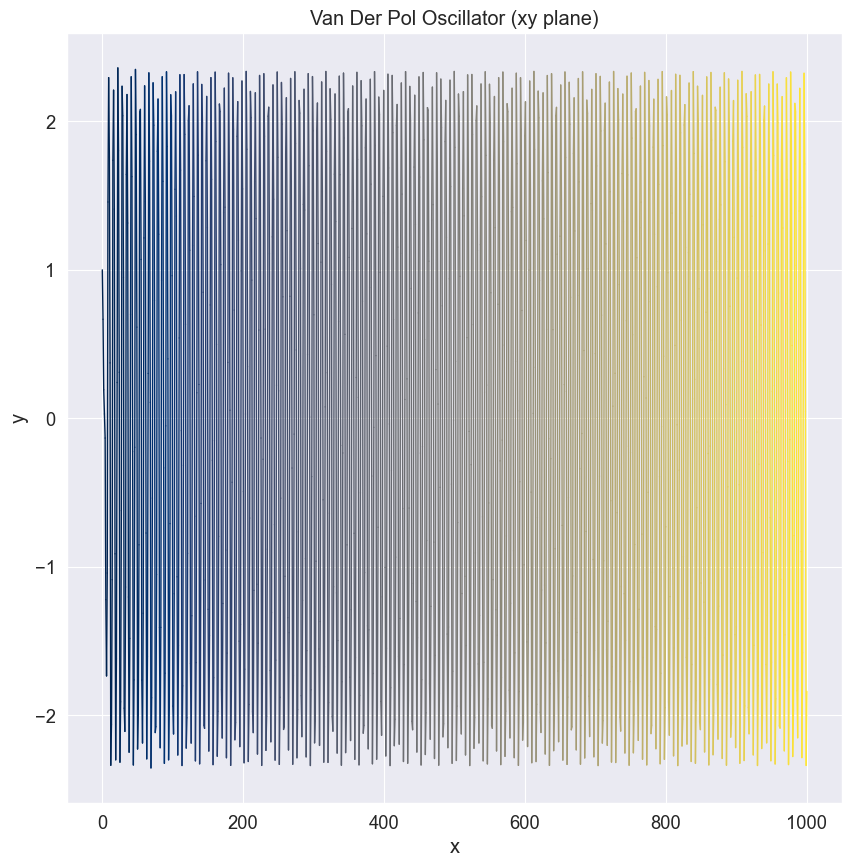

In [70]:
plot_vanderpol_2d(X, 1000)

In [71]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [72]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["choice", 0.9],           # the input scaling is fixed
        "ridge": ["choice", 1e-7],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [73]:
train_len = 100

X_train = X[:train_len]
y_train = X[1 : train_len + 1]

X_test = X[train_len : -1]
y_test = X[train_len + 1:]

dataset = ((X_train, y_train), (X_test, y_test))

In [74]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [02:19<00:00,  1.43trial/s, best loss: 0.26840897243593176]


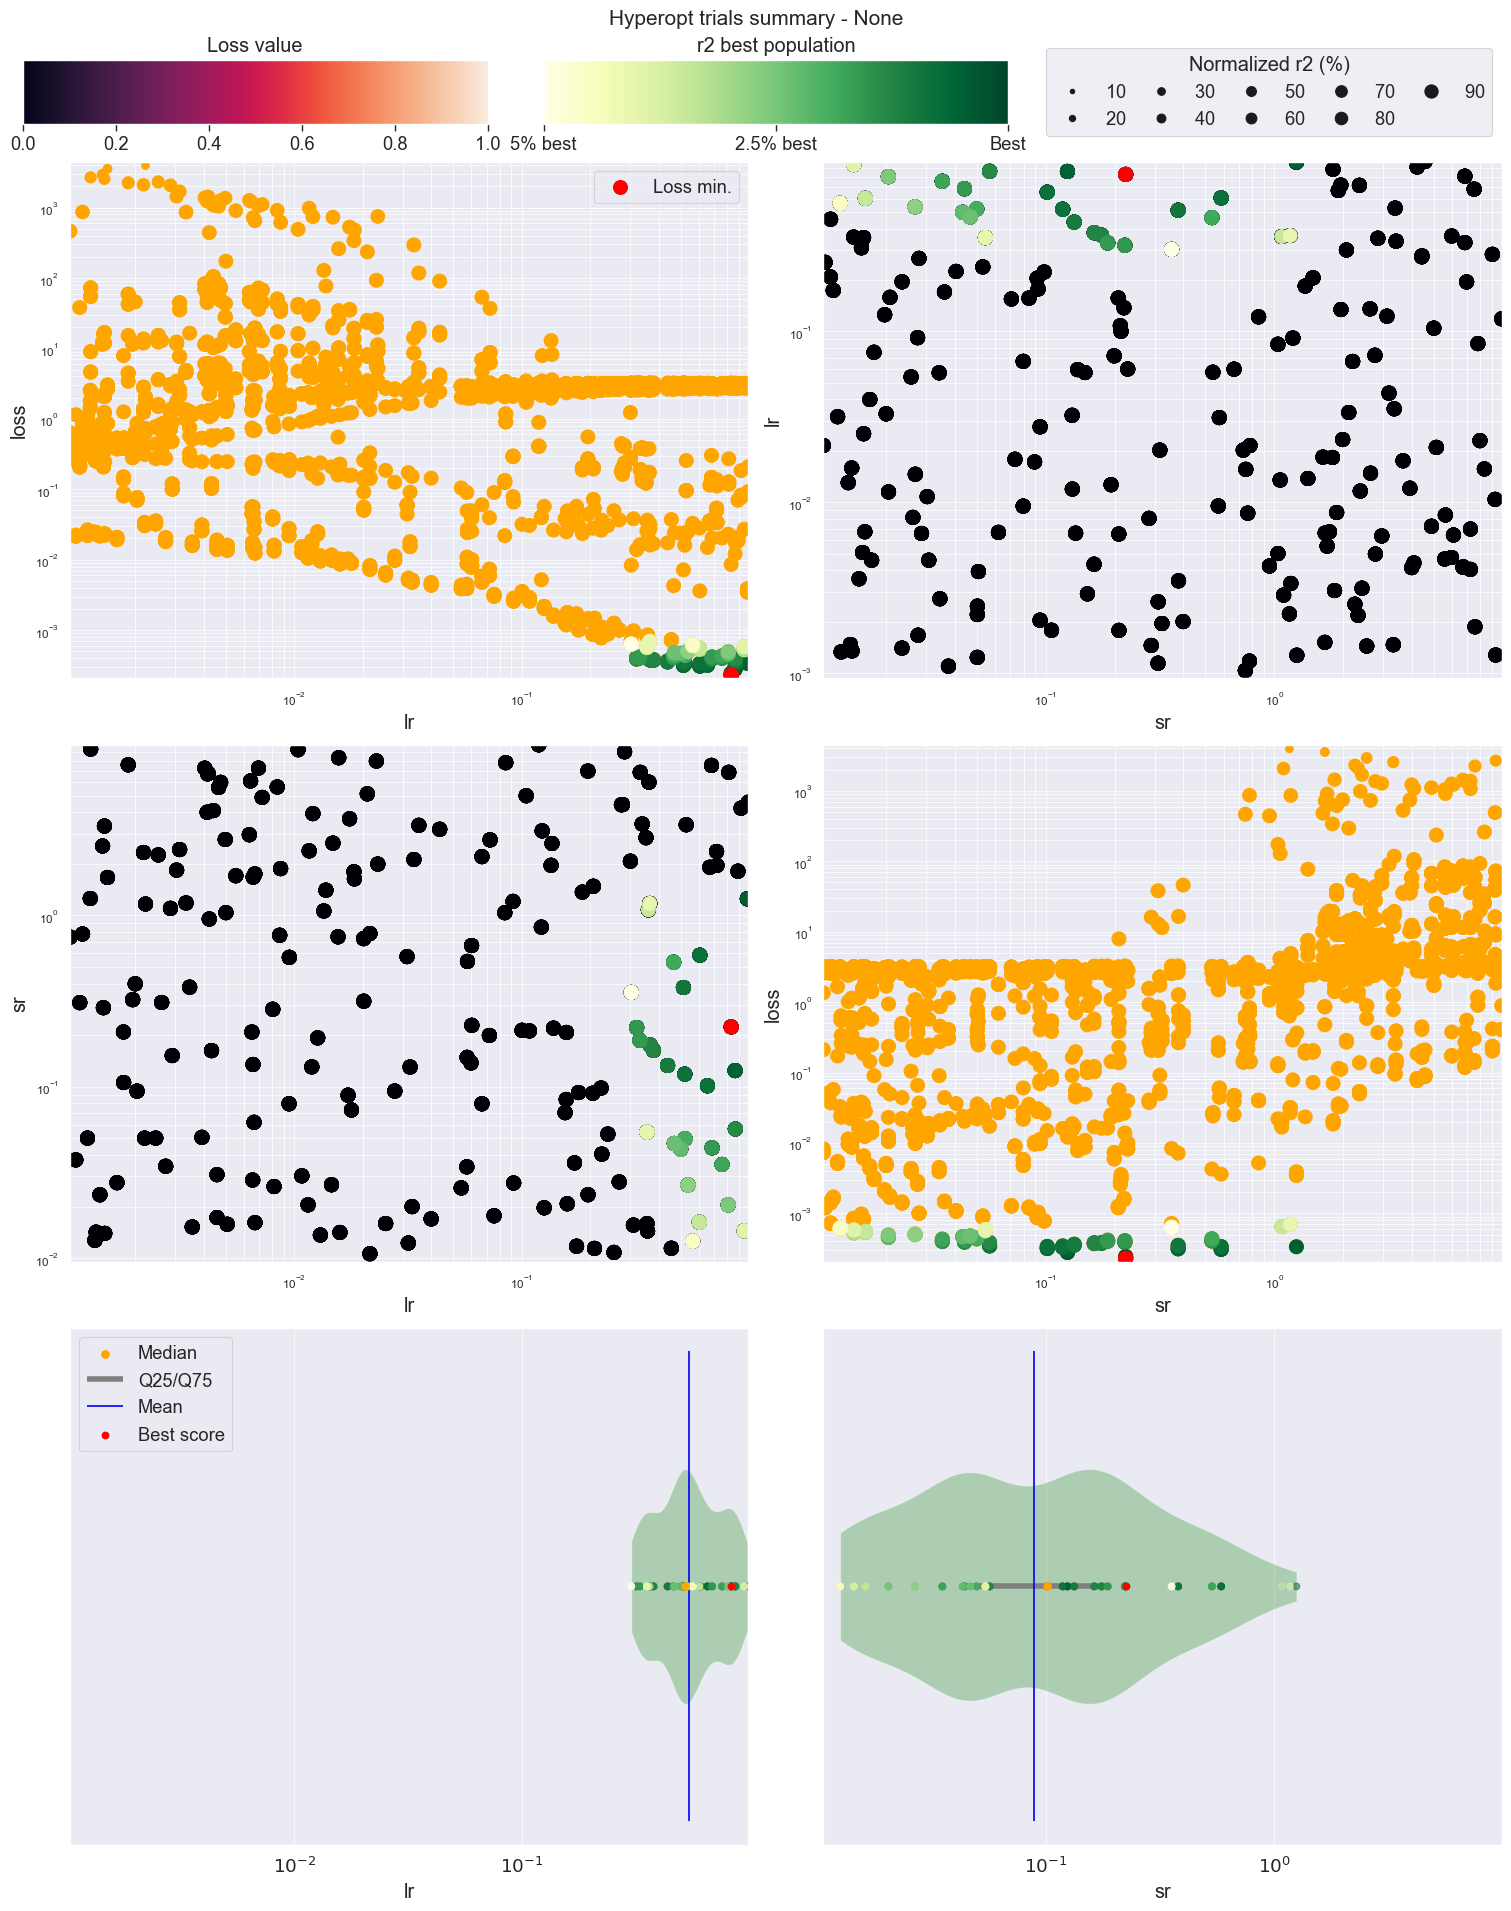

In [75]:
from reservoirpy.hyper import plot_hyperopt_report

fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr"), metric="r2")

In [76]:
best

({'N': 0,
  'iss': 0,
  'lr': 0.0010345463215508882,
  'ridge': 0,
  'seed': 0,
  'sr': 0.7476653587619372},
 <hyperopt.base.Trials at 0x28b611280>)

In [77]:
X_test.shape

(899, 3)

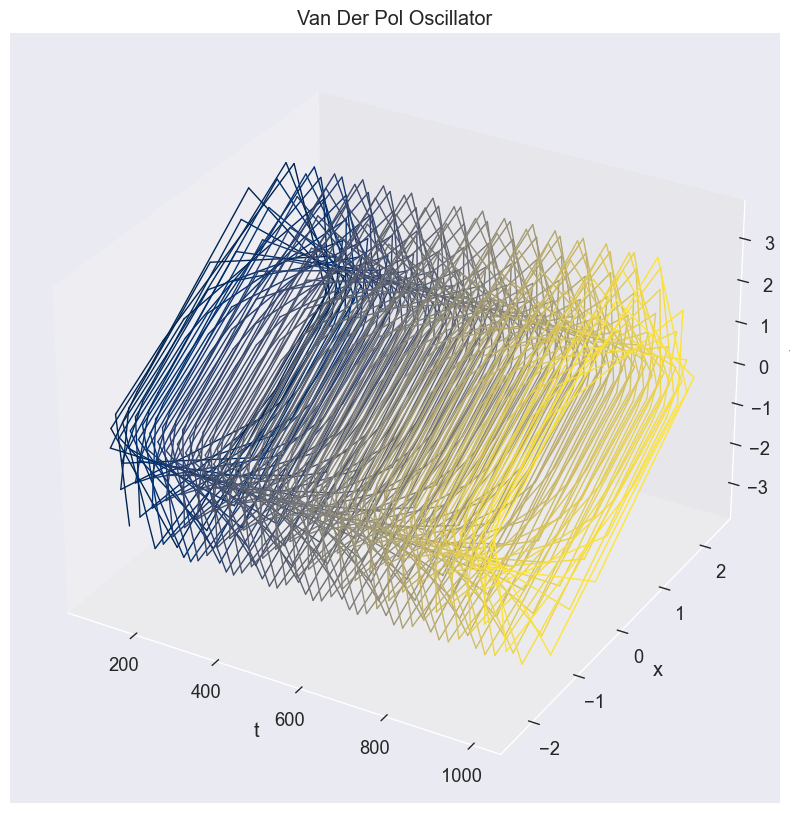

In [78]:
# 3D プロットの作成
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Van Der Pol Oscillator")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_zlabel("y")
ax.grid(False)
for i in range(timesteps-1):
    ax.plot(X_test[i:i+2, 0], X_test[i:i+2, 1], X_test[i:i+2, 2], color=plt.cm.cividis(255*i//899), lw=1.0)
plt.show()

ここまで、外力: $\sin(\omega t)$ がある場合

さらに外力がより複雑な場合を考えてみる。

試しに、外力の項がローレンツシステムのx成分であるときを考えてみる。